# **Twitter Disaster NLP**

In this notebook, we build a NLP classification model using bidirectional LSTM that predicts which Tweets are about real disasters and which one’s aren’t.

Workflow:
1. Tokenize the tweets and convert them into sequences.
2. Apply GLOVE embeddings to convert the sequences into tensors.
3. Build a bidirectional lstm model.
4. Make prediction on the test data

In [1]:
import os
import csv
import zipfile
import random
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import TweetTokenizer, NLTKWordTokenizer
from nltk.stem import WordNetLemmatizer

# **Data Review**

In [2]:
# reading data file
TRAINING_DIR = "/kaggle/input/nlp-getting-started/train.csv"

training_data = pd.read_csv(TRAINING_DIR)

In [3]:
#Visualised data
training_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
# check blank data
training_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

# **Data Processing**

In [6]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

**Preprocess train data**

In [7]:
# use tweet tonkenizer first
tk =TweetTokenizer()
texts = training_data.text.apply(tk.tokenize)

# lemmatize and lower the texts
lemmer = WordNetLemmatizer()
texts2 = [[lemmer.lemmatize(w).lower() for w in sentence] for sentence in texts]
train_sentences = [' '.join(txt) for txt in texts2]

**Tokenized train data**

In [8]:
OOV_TOKEN = "<OOV>"

# Instantiate the Tokenizer class, passing in the correct value for oov_token
tokenizer = Tokenizer(oov_token = OOV_TOKEN)
    
# Fit the tokenizer to the training sentences
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 21347 words

<OOV> token included in vocabulary


**Add Padding**

In [9]:
PADDING = 'post'

# Convert sentences to sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)

MAXLEN = max([len(i) for i in train_sequences])

# Pad the sequences using the correct padding, truncating and maxlen
train_pad_trunc_seq = pad_sequences(train_sequences, maxlen=MAXLEN, padding=PADDING)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Maxlen is {MAXLEN}.")

Padded and truncated training sequences have shape: (7613, 38)

Maxlen is 38.


In [10]:
# create labels
NUM_CLASSES = 2

cat_labels = tf.keras.utils.to_categorical(training_data.target,num_classes=NUM_CLASSES)

print(f"Labels have shape: {cat_labels.shape}\n")

Labels have shape: (7613, 2)



In [11]:
#download glove data for embedding
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip

--2022-12-21 07:50:33--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
Resolving huggingface.co (huggingface.co)... 18.235.116.140, 34.200.6.138, 54.86.30.45, ...
Connecting to huggingface.co (huggingface.co)|18.235.116.140|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/6471382cdd837544bf3ac72497a38715e845897d265b2b424b4761832009c837?response-content-disposition=attachment%3B%20filename%3D%22glove.6B.zip%22&Expires=1671868233&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3N0YW5mb3JkbmxwL2dsb3ZlLzY0NzEzODJjZGQ4Mzc1NDRiZjNhYzcyNDk3YTM4NzE1ZTg0NTg5N2QyNjViMmI0MjRiNDc2MTgzMjAwOWM4Mzc~cmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj1hdHRhY2htZW50JTNCJTIwZmlsZW5hbWUlM0QlMjJnbG92ZS42Qi56aXAlMjIiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE2NzE4NjgyMzN9fX1dfQ__&Signature=E4QZWXBkC2IEqJA3-lCQrpoSJbUFz6-jN5N4MTZhZ0heb02lKAQRbz6w7BpT3CwkQIzS6NL4gm0o-u

In [12]:
#unzip glove data
with zipfile.ZipFile("/kaggle/working/glove.6B.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/working/data/")

In [13]:
os.listdir("/kaggle/working/data/")

['glove.6B.100d.txt',
 'glove.6B.300d.txt',
 'glove.6B.50d.txt',
 'glove.6B.200d.txt']

In [14]:
# Define path to file containing the embeddings
GLOVE_FILE = '/kaggle/working/data/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [15]:
# check if embeddings are implemented
test_word = 'dog'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")


Vector representation of word dog looks like this:

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1.0235    -0.39695   -0.0056188  0.3

In [16]:
EMBEDDING_DIM = 100

# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

# **Model Building & Training**

In [17]:
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    """
    
    Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
        embeddings_matrix (array): predefined weights of the embeddings
    
    Returns:
        model (tf.keras Model): classifier model
    """
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        #tf.keras.layers.Conv1D(filters = 512,kernel_size= 3,activation='relu'), 
        #tf.keras.layers.SpatialDropout1D(0.2),
        #tf.keras.layers.MaxPool1D(),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(2, activation='softmax'),        
    ])
    
    optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999)
    #optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy']) 

    return model

In [18]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 5 * 10**(epoch / 20))

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

# Create untrained model
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

model.summary()

2022-12-21 07:51:07.232651: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 38, 100)           2134800   
_________________________________________________________________
bidirectional (Bidirectional (None, 38, 128)           84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 2,351,634
Trainable params: 216,834
Non-trainable params: 2,134,800
_________________________________________________________________


In [19]:
# Train the model and save the training history
tf.random.set_seed(1234)
history = model.fit(train_pad_trunc_seq, cat_labels, 
                    epochs=10,  
                    batch_size = 128,
                    callbacks = [early_stopping],
                    validation_split = 0.2)

Epoch 1/10


2022-12-21 07:51:08.876552: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


48/48 [==============================] - 17s 203ms/step - loss: 0.5183 - accuracy: 0.7509 - val_loss: 0.4444 - val_accuracy: 0.8063
Epoch 2/10
48/48 [==============================] - 8s 168ms/step - loss: 0.4411 - accuracy: 0.8005 - val_loss: 0.4202 - val_accuracy: 0.8109
Epoch 3/10
48/48 [==============================] - 8s 168ms/step - loss: 0.4177 - accuracy: 0.8164 - val_loss: 0.4348 - val_accuracy: 0.8109
Epoch 4/10
48/48 [==============================] - 9s 169ms/step - loss: 0.4015 - accuracy: 0.8241 - val_loss: 0.4352 - val_accuracy: 0.8011
Epoch 5/10
48/48 [==============================] - 8s 173ms/step - loss: 0.3924 - accuracy: 0.8274 - val_loss: 0.4265 - val_accuracy: 0.8089


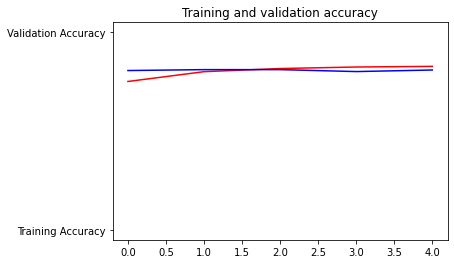

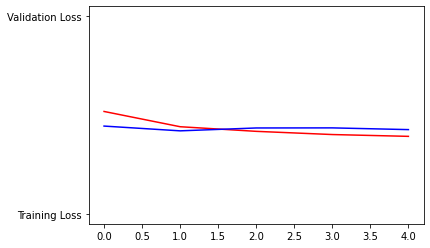

In [20]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

# **Prediction on Test data**

**Test data processing**

In [21]:
TESTING_DIR = "/kaggle/input/nlp-getting-started/test.csv"

testing_data = pd.read_csv(TESTING_DIR)

In [22]:
# apply tweet tokenizer first
texts = testing_data.text.apply(tk.tokenize)
# lemmatize and lower the texts
texts2 = [[lemmer.lemmatize(w).lower() for w in sentence] for sentence in texts]
test_sentences = [' '.join(txt) for txt in texts2]

In [23]:
# convert sentences to sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# pad the sequences using the correct padding, truncating and maxlen
test_pad_trunc_seq = pad_sequences(test_sequences, maxlen=MAXLEN, padding=PADDING)

print(f'test_pad_trunc_seq.shape = {test_pad_trunc_seq.shape}')

test_pad_trunc_seq.shape = (3263, 38)


**Predict test data**

In [24]:
# use trained model to predict on test data 
testing_labels = model.predict(test_pad_trunc_seq)

**View prediction**

In [25]:
print(testing_labels)

[[0.14090197 0.8590981 ]
 [0.39156336 0.6084367 ]
 [0.3095157  0.6904843 ]
 ...
 [0.19579841 0.80420166]
 [0.38406026 0.61593974]
 [0.6513729  0.3486271 ]]


In [26]:
test = pd.read_csv(TESTING_DIR)

In [27]:
#turn categorical results into 0/1
test_labels = np.argmax(testing_labels, axis=1)

#adding the 'target' column for prediction results
test['target'] = test_labels

In [28]:
# check overall predictions
test

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


In [29]:
# check some disaster tweet predictions
test[test.target == 1]

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3257,10858,NaN,NaN,The death toll in a #IS-suicide car bombing on...,1
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1


In [30]:
# check some non-disaster tweet predictions
test[test.target == 0]

,id,keyword,location,text,target
6,21,NaN,NaN,They'd probably still show more life than Arse...,0
7,22,NaN,NaN,Hey! How are you?,0
8,27,NaN,NaN,What a nice hat?,0
9,29,NaN,NaN,Fuck off!,0
10,30,NaN,NaN,No I don't like cold!,0
...,...,...,...,...,...
3249,10816,wrecked,los angeles,@thrillhho jsyk I haven't stopped thinking abt...,0
3250,10820,wrecked,"Brussels, Belgium",@stighefootball Begovic has been garbage. He g...,0
3251,10828,wrecked,NaN,Wrecked today got my hattrick ????,0
3256,10857,NaN,NaN,To conference attendees! The blue line from th...,0


In [31]:
# generate submission results 
submission = test[['id','target']]
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [32]:
submission.to_csv('submission_biLSTM.csv', index = False)